<a href="https://colab.research.google.com/github/andrei-radulescu-banu/stat453-deep-learning-ss21/blob/main/L14/3-all-convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install watermark
!pip install colab-env --upgrade
import colab_env
colab_env.envvar_handler.add_env("CUBLAS_WORKSPACE_CONFIG", ":4096:8", overwrite=True)
!git clone https://github.com/andrei-radulescu-banu/stat453-deep-learning-ss21.git
import sys, os
sys.path.append("/content/stat453-deep-learning-ss21/L14")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 6.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colab-env: filename=colab_env-0.2.0-py3-none-any.whl size=3837 sha256=af7ae3376d2b70b2132af3dec7a8849b38d7fa19b790745d01340e66d8e9a1e0
  Stored in directory: /root/.cache/pip/wheels/bb/ca/e8/3d25b6abb4ac719ecb9e837bb75f2a9b980430005fb12a9107
Successfully built colab-env
Mounted at /content/gdrive
Cloning into 'stat453-deep-learning-ss21'...
remote: Enumerating objects: 1239, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 1239 (delta 119), reused 4 (delta 4), pack-reused 1050
Receiving objects: 100% (1239/1239), 116.02 MiB | 30.84 MiB/s, done.
Resolving deltas: 100% (223/223), done.


STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

In [3]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

torch: 1.12.1+cu113



# All-Convolutional Net on Cifar-10

## Imports

In [4]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

## Settings and Dataset

In [6]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [8]:
##########################
### CIFAR-10 DATASET
##########################

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),        
    torchvision.transforms.CenterCrop((64, 64)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


## Model

In [9]:
##########################
### MODEL
##########################


class AllConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        
        self.net = torch.nn.Sequential(
                      torch.nn.Conv2d(in_channels=3,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1,
                                      bias=False),
                      torch.nn.BatchNorm2d(16),
                      torch.nn.ReLU(inplace=True),
                      torch.nn.Conv2d(in_channels=16,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1,
                                      bias=False),   
                      torch.nn.BatchNorm2d(16),
                      torch.nn.ReLU(inplace=True),
                      torch.nn.Conv2d(in_channels=16,
                                      out_channels=32,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1,
                                      bias=False),        
                      torch.nn.BatchNorm2d(32),
                      torch.nn.ReLU(inplace=True),                        
                      torch.nn.Conv2d(in_channels=32,
                                      out_channels=32,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1,
                                      bias=False),      
                      torch.nn.BatchNorm2d(32),
                      torch.nn.ReLU(inplace=True),       
                      torch.nn.Conv2d(in_channels=32,
                                      out_channels=64,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1,
                                      bias=False),   
                      torch.nn.BatchNorm2d(64),
                      torch.nn.ReLU(inplace=True),
                      torch.nn.Conv2d(in_channels=64,
                                      out_channels=64,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1,
                                      bias=False),     
                      torch.nn.BatchNorm2d(64),
                      torch.nn.ReLU(inplace=True),
                      torch.nn.Conv2d(in_channels=64,
                                      out_channels=num_classes,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1,
                                      bias=False),    
                      torch.nn.BatchNorm2d(10),
                      torch.nn.ReLU(inplace=True),
                      torch.nn.AdaptiveAvgPool2d(1),
                      torch.nn.Flatten()
    )


    def forward(self, x):
        
        x = self.net(x)
        #probas = torch.softmax(x, dim=1)
        return x

Epoch: 001/002 | Batch 0000/0175 | Loss: 2.3527
Epoch: 001/002 | Batch 0100/0175 | Loss: 1.5329
Epoch: 001/002 | Train: 39.35% | Validation: 40.22%
Time elapsed: 1.48 min
Epoch: 002/002 | Batch 0000/0175 | Loss: 1.3277
Epoch: 002/002 | Batch 0100/0175 | Loss: 1.2308
Epoch: 002/002 | Train: 56.51% | Validation: 56.14%
Time elapsed: 2.81 min
Total Training Time: 2.81 min
Test accuracy 56.10%


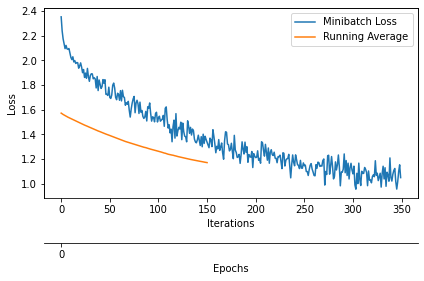

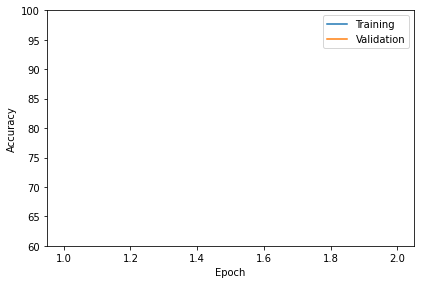

In [10]:
model = AllConvNet(num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

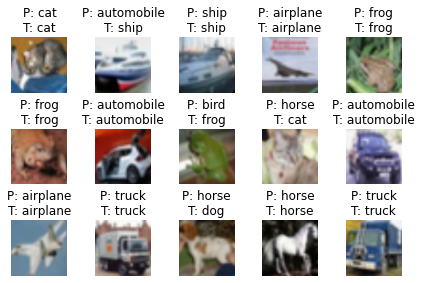

In [11]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

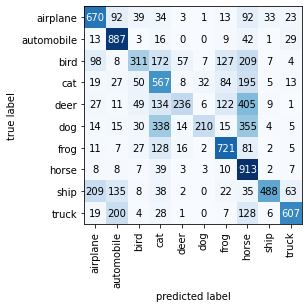

In [12]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()